In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict, Counter
from functools import reduce
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D
import torch

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc

In [4]:
weight_scales = [0.5, 0.9, 1.0, 1.1, 1.5, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0, 50.0, 100.0, 125.0, 150.0, 200.0]

In [5]:
import configuration
import model_registry
import data.build
import data.constants as dconst
import model.constants as mconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification, Ensemble
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model
import seed
from train import train_model
from model.build import make_model

In [6]:
import logging as l

l.basicConfig(level=l.INFO)

In [7]:
registry = model_registry.ModelRegistry()

In [8]:
dataset = dconst.CORA_FULL

spectral_norm_conf = {'model' : {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 200.0,
    },}

config = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
    },
    **(spectral_norm_conf),
    run = {
        'use_default_configuration' : True,
    },
)
config.model.use_bias = True
if config.run.use_default_configuration:
    configuration.update_with_default_configuration(config)
    
print(config.run.use_default_configuration)

INFO:root:Set configuration value data.base_labels to default ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intelligence/Machine_Learning/Rule_Learning', 'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning', 'Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance']
INFO:root:Set configuration value data.corpus_labels to default ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intell

True


In [9]:
data_split_seed = seed.data_split_seeds()[config.run.split_idx]
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[config.run.initialization_idx]))
model_seed = next(model_seed_generator)
config.registry.model_seed = model_seed
config.registry.split_seed = data_split_seed
config.training.early_stopping.patience = 50
config.training.early_stopping.min_delta = 0.01

In [10]:
data_dict, fixed_vertices = data.build.load_data_from_configuration(config.data, data_split_seed)

INFO:root:Found precomputed dataset split at /nfs/students/fuchsgru/dataset_registry/2361285485.pt


In [11]:
from torch_geometric.data import DataLoader
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
registry[config]

'/nfs/students/fuchsgru/model_registry/3556468068.ckpt'

In [13]:
# Find model checkpoints for all weight scales
from copy import deepcopy

weight_scale_to_path = {}
for w in weight_scales:
    config_w = deepcopy(config)
    config_w.model.weight_scale = w
    weight_scale_to_path[w] = registry[config_w]
    

In [14]:
config_no_sn = deepcopy(config)
config_no_sn.model.use_spectral_norm = False
config_no_sn.model.weight_scale = 1.0
config_no_sn.model.residual = False
weight_scale_to_path[np.nan] = registry[config_no_sn]

In [15]:
weight_scale_to_path[np.nan]

'/nfs/students/fuchsgru/model_registry/463723298332759286-1650045600-1699502-1451882634.ckpt'

In [16]:
weight_scale_to_path

{0.5: '/nfs/students/fuchsgru/model_registry/499666249.ckpt',
 0.9: '/nfs/students/fuchsgru/model_registry/3138328699.ckpt',
 1.0: '/nfs/students/fuchsgru/model_registry/2390243716.ckpt',
 1.1: '/nfs/students/fuchsgru/model_registry/3449236635.ckpt',
 1.5: '/nfs/students/fuchsgru/model_registry/3287463577.ckpt',
 2.0: '/nfs/students/fuchsgru/model_registry/2688770595.ckpt',
 5.0: '/nfs/students/fuchsgru/model_registry/1119208936.ckpt',
 10.0: '/nfs/students/fuchsgru/model_registry/3110587511.ckpt',
 15.0: '/nfs/students/fuchsgru/model_registry/3344602273.ckpt',
 20.0: '/nfs/students/fuchsgru/model_registry/92374506.ckpt',
 30.0: '/nfs/students/fuchsgru/model_registry/1708154259.ckpt',
 50.0: '/nfs/students/fuchsgru/model_registry/47177914.ckpt',
 100.0: '/nfs/students/fuchsgru/model_registry/2763998846.ckpt',
 125.0: '/nfs/students/fuchsgru/model_registry/5462121987510569481-1649882376-2096922-718461544.ckpt',
 150.0: '/nfs/students/fuchsgru/model_registry/<built-in function hash>-1649

In [17]:
config.run.use_pretrained_model = True

if not torch.cuda.is_available():
    config.training.gpus = 0
    
config.training

TrainingConfiguration(max_epochs=1000, min_epochs=None, learning_rate=0.001, early_stopping=EarlyStoppingConfiguration(patience=50, mode='min', monitor='val_loss', min_delta=0.01), gpus=0, weight_decay=0.001, suppress_stdout=True, train_model=True, self_training=False, num_warmup_epochs=50, singular_value_bounding=False, singular_value_bounding_eps=0.01, orthonormal_weight_regularization_strength=0.0, orthonormal_weight_scale=1.0, finetuning=FinetuningConfiguration(max_epochs=10, min_epochs=1, enable=False, reconstruction=None, feature_reconstruction=None, reconstruction_weight=None, feature_reconstruction_weight=None), temperature_scaling=None)

In [18]:
import os.path as osp
run_artifact_dir = artifact_dir = osp.join(config.logging.artifact_dir, 'spectral-structure')

In [19]:
weight_scale_to_spectrum = {}

from tqdm import tqdm
for weight_scale, path in tqdm(weight_scale_to_path.items()):
    
    config_w = deepcopy(config)
    if not np.isfinite(weight_scale):
        config_w.model.weight_scale = 1.0
        config_w.model.use_spectral_norm = False
        config_w.model.residual = False
    else:
        config_w.model.weight_scale = weight_scale
    
    model = make_model(config_w, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])).eval()
    model = train_model(model, config_w, run_artifact_dir, data_loaders, logger=None).eval()
    model.clear_and_disable_cache()
        
    data_val = data_dict[dconst.VAL][0]
    with torch.no_grad():
        acc = (model(data_val).get_predictions().argmax(1)[data_val.mask] == data_val.y[data_val.mask]).float().mean().item()
        print(weight_scale, acc)
        
    weight = (model.backbone.convs[0].conv.lin.linear.weight.detach().cpu().numpy())
    u, s, v = np.linalg.svd(weight, full_matrices=False)
    weight_scale_to_spectrum[weight_scale] = s
  

  0%|          | 0/17 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/499666249.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/499666249.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
  6%|▌         | 1/17 [00:02<00:41,  2.61s/it]

0.5 0.22857142984867096


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3138328699.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3138328699.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


0.9 0.7571428418159485


 12%|█▏        | 2/17 [00:05<00:41,  2.78s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/2390243716.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/2390243716.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
 18%|█▊        | 3/17 [00:11<01:02,  4.47s/it]

1.0 0.8214285969734192


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3449236635.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3449236635.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
 24%|██▎       | 4/17 [00:14<00:49,  3.78s/it]

1.1 0.800000011920929


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3287463577.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3287463577.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


1.5 0.8357142806053162


 29%|██▉       | 5/17 [00:17<00:40,  3.40s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/2688770595.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/2688770595.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


2.0 0.8285714387893677


 35%|███▌      | 6/17 [00:20<00:37,  3.42s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1119208936.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1119208936.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
 41%|████      | 7/17 [00:24<00:33,  3.36s/it]

5.0 0.8500000238418579


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3110587511.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3110587511.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
 47%|████▋     | 8/17 [00:27<00:29,  3.31s/it]

10.0 0.8357142806053162


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3344602273.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3344602273.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
 53%|█████▎    | 9/17 [00:29<00:24,  3.06s/it]

15.0 0.8357142806053162


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/92374506.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/92374506.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


20.0 0.8285714387893677


 59%|█████▉    | 10/17 [00:33<00:22,  3.18s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1708154259.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1708154259.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


30.0 0.8214285969734192


 65%|██████▍   | 11/17 [00:36<00:19,  3.31s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/47177914.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/47177914.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


50.0 0.8142856955528259


 71%|███████   | 12/17 [00:40<00:16,  3.39s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/2763998846.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/2763998846.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


100.0 0.8214285969734192


 76%|███████▋  | 13/17 [00:43<00:12,  3.14s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/5462121987510569481-1649882376-2096922-718461544.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/5462121987510569481-1649882376-2096922-718461544.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


125.0 0.8214285969734192


 82%|████████▏ | 14/17 [00:50<00:12,  4.32s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/<built-in function hash>-1649881518-241675-3387505085.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/<built-in function hash>-1649881518-241675-3387505085.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


150.0 0.8428571224212646


 88%|████████▊ | 15/17 [00:56<00:10,  5.04s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3556468068.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3556468068.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


200.0 0.8428571224212646


 94%|█████████▍| 16/17 [00:59<00:04,  4.43s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/463723298332759286-1650045600-1699502-1451882634.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/463723298332759286-1650045600-1699502-1451882634.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
100%|██████████| 17/17 [01:07<00:00,  3.97s/it]

nan 0.8428571224212646


In [20]:
weight_scale_to_spectrum_reco = {}

from tqdm import tqdm
for weight_scale in tqdm([np.nan] + weight_scales):
    
    config_w = deepcopy(config)
    config_w.model.reconstruction.loss_weight = 1.0
    config_w.model.reconstruction.reconstruction_type = mconst.ENERGY
    
    if not np.isfinite(weight_scale):
        config_w.model.weight_scale = 1.0
        config_w.model.use_spectral_norm = False
        config_w.model.residual = False
    else:
        config_w.model.weight_scale = weight_scale
    
    model = make_model(config_w, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])).eval()
    model = train_model(model, config_w, run_artifact_dir, data_loaders, logger=None).eval()
    model.clear_and_disable_cache()
        
    data_val = data_dict[dconst.VAL][0]
    with torch.no_grad():
        acc = (model(data_val).get_predictions().argmax(1)[data_val.mask] == data_val.y[data_val.mask]).float().mean().item()
        print(weight_scale, acc)
        
    weight = (model.backbone.convs[0].conv.lin.linear.weight.detach().cpu().numpy())
    u, s, v = np.linalg.svd(weight, full_matrices=False)
    weight_scale_to_spectrum_reco[weight_scale] = s
  

  0%|          | 0/17 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/499136641.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/499136641.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
  6%|▌         | 1/17 [00:06<01:46,  6.65s/it]

nan 0.8428571224212646


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3401992236.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3401992236.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


0.5 0.7857142686843872


 12%|█▏        | 2/17 [00:13<01:41,  6.73s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/2291140496.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/2291140496.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
 18%|█▊        | 3/17 [00:19<01:31,  6.56s/it]

0.9 0.8500000238418579


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1340392845.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1340392845.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


1.0 0.8285714387893677


 24%|██▎       | 4/17 [00:25<01:23,  6.39s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1319606793.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1319606793.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


1.1 0.8500000238418579


 29%|██▉       | 5/17 [00:32<01:16,  6.37s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3308592915.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3308592915.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


1.5 0.8642857074737549


 35%|███▌      | 6/17 [00:38<01:11,  6.48s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/518399070.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/518399070.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


2.0 0.8642857074737549


 41%|████      | 7/17 [00:45<01:04,  6.45s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/220533074.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/220533074.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


5.0 0.8428571224212646


 47%|████▋     | 8/17 [00:51<00:56,  6.33s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1861577590.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1861577590.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
 53%|█████▎    | 9/17 [00:57<00:49,  6.23s/it]

10.0 0.8357142806053162


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1989941200.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1989941200.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


15.0 0.8214285969734192


 59%|█████▉    | 10/17 [01:03<00:44,  6.31s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/932497260.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/932497260.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


20.0 0.8214285969734192


 65%|██████▍   | 11/17 [01:10<00:38,  6.43s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/76676086.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/76676086.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


30.0 0.8214285969734192


 71%|███████   | 12/17 [01:16<00:31,  6.37s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/2814679549.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/2814679549.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
 76%|███████▋  | 13/17 [01:23<00:25,  6.35s/it]

50.0 0.8357142806053162


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1495764648.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1495764648.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


100.0 0.8428571224212646


 82%|████████▏ | 14/17 [01:29<00:18,  6.21s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/-7177346471657512231-1649883028-8262556-3600097468.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/-7177346471657512231-1649883028-8262556-3600097468.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


125.0 0.8285714387893677


 88%|████████▊ | 15/17 [01:36<00:13,  6.51s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/<built-in function hash>-1649867619-1816854-2904736419.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/<built-in function hash>-1649867619-1816854-2904736419.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


150.0 0.8142856955528259


 94%|█████████▍| 16/17 [01:43<00:06,  6.69s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/3202218202.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/3202218202.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
100%|██████████| 17/17 [01:49<00:00,  6.42s/it]

200.0 0.8214285969734192


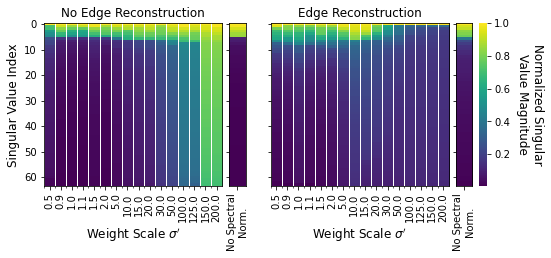

In [22]:

xs = [np.nan] + list(sorted(weight_scales))
spectrums = np.array([weight_scale_to_spectrum[ws] for ws in xs])
spectrums /= spectrums.max(axis=1, keepdims=True)

spectrums_reco = np.array([weight_scale_to_spectrum_reco[ws] for ws in xs])
spectrums_reco /= spectrums_reco.max(axis=1, keepdims=True)

fig, axs = plt.subplots(1, 3 * 2, figsize=(8, 3), gridspec_kw = {
            'width_ratios' : [0.8, 0.075, 0.05] * 2, 'wspace' : 0.1, 'hspace' : 0.1,
    }, sharey=True, sharex=False, squeeze=False)

im = axs[0, 0].imshow(spectrums[1:].T, aspect='auto', interpolation='none')
_ = axs[0, 1].imshow(spectrums[:1].T, aspect='auto', interpolation='none')
im_reco = axs[0, 3].imshow(spectrums_reco[1:].T, aspect='auto', interpolation='none')
_ = axs[0, 4].imshow(spectrums_reco[:1].T, aspect='auto', interpolation='none')

for ax in axs[0, 0::3].flatten():
    ax.set_xticks(np.arange(len(xs) - 1))
    ax.set_xticklabels(xs[1:], rotation=90)
    ax.set_xlabel('Weight Scale $\\sigma^\\prime$', fontsize=12)
    ax.set_xticks(np.arange(len(xs) - 1) - 0.5, minor=True)
    ax.grid(which='minor', color='w', axis='x', linestyle='-', linewidth=1)
                  
axs[0, 0].set_title('No Edge Reconstruction', fontsize=12)
axs[0, 3].set_title('Edge Reconstruction', fontsize=12)

for ax in axs[0, 1::3].flatten():
    ax.set_xticks([0])
    ax.set_xticklabels(['No Spectral\nNorm.'], rotation=90)
    
axs[0, 0].set_ylabel('Singular Value Index', fontsize=12)
for ax in axs[:, 2::3].flatten():
    ax.set_visible(False)
    
cb = fig.colorbar(im, ax=axs[0, 5], fraction=1.0)
cb.set_label('Normalized Singular\nValue Magnitude', fontsize=12, rotation=270, labelpad=34)
cb.outline.set_visible(False)

fig.savefig(f'thesis_nbs/spectral_structure_vs_weight_scale_and_reco_{dataset}.pdf', bbox_inches='tight')

In [21]:
3

3

In [22]:
xs = [np.nan] + list(sorted(weight_scales))

spectrums = np.zeros((len(xs), config.model.hidden_sizes[-1]))
spectrums[...] = np.nan
spectrums_reco = spectrums.copy()

for ws, sp in weight_scale_to_spectrum.items():
    spectrums[xs.index(ws)] = sp
    
for ws, sp in weight_scale_to_spectrum_reco.items():
    spectrums_reco[xs.index(ws)] = sp

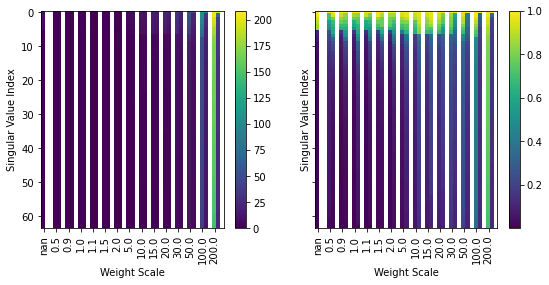

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
normalized = spectrums / spectrums.max(1, keepdims=True)
normalized_reco = spectrums_reco / spectrums_reco.max(1, keepdims=True)

pad = 3
im = np.zeros((pad * len(xs), spectrums.shape[1]))
im[...] = np.nan
im_norm = im.copy()

im[::pad] = spectrums
im[1::pad] = spectrums_reco
im_norm[::pad] = normalized
im_norm[1::pad] = normalized_reco
m1 = axs[0].imshow(im.T, aspect='auto')
m2 = axs[1].imshow(im_norm.T, aspect='auto')

for ax in axs.flatten():
    ax.set_xticks(np.arange(len(xs) * pad)[::pad] + 0.1 * pad)
    ax.set_xticklabels(xs, rotation=90)
    ax.set_xlabel('Weight Scale')
    ax.set_ylabel('Singular Value Index')
    
fig.colorbar(m1, ax=axs[0])
fig.colorbar(m2, ax=axs[1])



In [24]:
spectrums_reco[-1], spectrums[-1]

(array([200.00004578,  69.28833008,  42.71522141,  36.44332504,
         35.69011688,  34.71691132,  34.23143387,  32.73820496,
         32.64463043,  32.42222214,  32.13044357,  31.58028984,
         31.52342606,  31.12657166,  30.77138329,  30.59985352,
         30.4170475 ,  30.24229813,  30.1465168 ,  29.74454689,
         29.61998749,  29.43000221,  29.24287415,  29.0708313 ,
         28.96914101,  28.93482971,  28.71854973,  28.64015579,
         28.50154495,  28.42829514,  28.17277718,  28.10844803,
         27.99074554,  27.88973999,  27.79063416,  27.73232079,
         27.61681175,  27.36782837,  27.26861382,  27.21893692,
         27.06132507,  26.92279625,  26.75756073,  26.69062424,
         26.57859421,  26.39891624,  26.3042717 ,  26.15546989,
         26.06428719,  26.05530357,  26.00053024,  25.78278923,
         25.59965324,  25.38969231,  25.25441933,  25.02100563,
         24.97411156,  24.79941368,  24.72810173,  24.43125153,
         24.3802433 ,  24.14924622,  23.

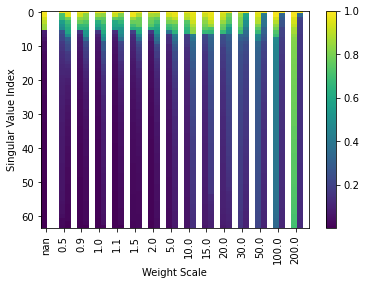

In [25]:
fig, ax = plt.subplots()
m2 = ax.imshow(im_norm.T, aspect='auto')

ax.set_xticks(np.arange(len(xs) * pad)[::pad] + 0.1 * pad)
ax.set_xticklabels(xs, rotation=90)
ax.set_xlabel('Weight Scale')
ax.set_ylabel('Singular Value Index')

fig.colorbar(m2)

In [26]:




m1 = axs[0].imshow((spectrums), aspect='auto')
m2 = axs[1].imshow((normalized), aspect='auto')
axs[0].set_title('Unnormalized')
axs[1].set_title('Normalized')
for ax in axs.flatten():
    ax.set_xticks(range(len(weight_scales + [np.nan])))
    ax.set_xticklabels(weight_scales + [np.nan])
    ax.set_xlabel('Weight Scale')
    ax.set_ylabel('Singular Value Index')
    
fig.colorbar(m1, ax=axs[0])
fig.colorbar(m2, ax=axs[1])




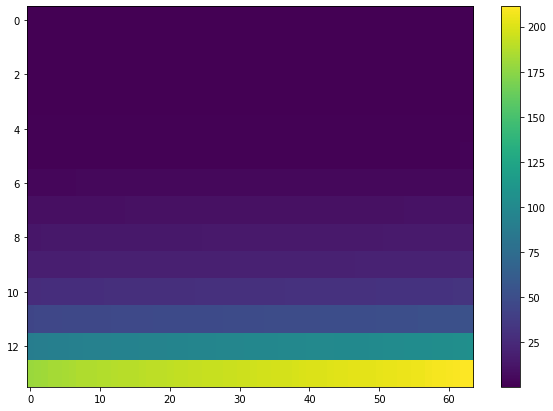

In [116]:
fig, ax = plt.subplots(figsize=(10, 7))
m = ax.imshow((spectrums[:, ::-1]), aspect='auto')
fig.colorbar(m)

In [117]:
spectrums.shape

(14, 64)

In [75]:
import torch
torch.load(weight_scale_to_path[0.5], map_location=torch.device('cpu'))

{'epoch': 46,
 'global_step': 46,
 'pytorch-lightning_version': '1.5.10',
 'state_dict': OrderedDict([('backbone.convs.0.conv.bias',
               tensor([ 0.0186,  0.0079,  0.0062,  0.0169, -0.0052,  0.0171,  0.0165,  0.0125,
                        0.0307,  0.0120,  0.0274,  0.0236,  0.0029, -0.0055,  0.0072,  0.0208,
                        0.0080,  0.0046, -0.0072,  0.0084,  0.0206,  0.0184,  0.0149,  0.0135,
                        0.0046,  0.0315,  0.0082,  0.0254,  0.0293,  0.0092, -0.0014,  0.0057,
                        0.0076,  0.0020,  0.0046,  0.0200, -0.0012,  0.0023,  0.0050, -0.0013,
                        0.0150,  0.0199,  0.0283,  0.0210,  0.0287, -0.0032, -0.0021, -0.0089,
                       -0.0036,  0.0279,  0.0290,  0.0080,  0.0077,  0.0170,  0.0214,  0.0118,
                        0.0096,  0.0092,  0.0093, -0.0033,  0.0217,  0.0095,  0.0122,  0.0267])),
              ('backbone.convs.0.conv.lin.linear.bias',
               tensor([-0.0021,  0.0223,  0.0112

In [65]:
from collections import Counter
cfgs = defaultdict(list)

for cfg, path in registry.items():
    if cfg.data.dataset == dc.CORA_FULL and cfg.data.ood_type == dc.PERTURBATION and \
        cfg.data.setting == dc.HYBRID and cfg.model.weight_scale == 200 and cfg.model.residual and \
        not cfg.model.use_spectral_norm_on_last_layer and cfg.model.reconstruction.loss_weight == 0:
        
        cfgs[(cfg.registry.model_seed, cfg.registry.split_seed)].append(cfg)

In [66]:
cfgs[(1952926171, 3362550210)][0].registry_configuration

{'model': {'hidden_sizes': [64],
  'linear_classification': False,
  'weight_scale': 200.0,
  'use_spectral_norm': True,
  'model_type': 'gcn',
  'use_bias': True,
  'activation': 'leaky_relu',
  'leaky_relu_slope': 0.01,
  'residual': True,
  'residual_pre_activation': True,
  'freeze_residual_projection': False,
  'dropout': 0.0,
  'drop_edge': 0.0,
  'use_spectral_norm_on_last_layer': False,
  'use_bjorck_norm_on_last_layer': False,
  'use_forbenius_norm_on_last_layer': False,
  'use_rescaling_on_last_layer': False,
  'use_residual_on_last_layer': False,
  'use_rescaling': False,
  'cached': True,
  'self_loop_fill_value': 1.0,
  'use_forbenius_norm': False,
  'use_bjorck_norm': False,
  'forbenius_norm': 1.0,
  'initialization_scale': 1.0,
  'reconstruction': {'loss_weight': 0.0,
   'sample': True,
   'num_samples': 100,
   'seed': 1337,
   'reconstruction_type': 'autoencoder',
   'cached': True,
   'margin_constrastive_loss': 0.0},
  'feature_reconstruction': {'loss_weight': 0.0,


In [50]:
def deepdictcmp(a, b, prefix=[]):
    keys = set(a.keys()).union(set(b.keys()))
    for k in keys:
        k_print = '.'.join(prefix + [k])
        if k not in a:
            print(f'{k_print} not in first but second')
        elif k not in b:
            print(f'{k_print} not in second but first')
        else:
            v_a, v_b = a[k], b[k]
            if type(v_a) != type(v_b):
                print(f'Mismatching types for {k_print}: First: {type(v_a)}, second : {(type(v_b))}')
            elif isinstance(v_a, dict):
                deepdictcmp(v_a, v_b, prefix=prefix + [k])
            elif v_a != v_b:
                print(f'Mismatch at {k_print}: First : {v_a}, Second: {v_b}')
            
        
        
    
    

In [69]:
for other_l in cfgs.values():
    for other in other_l:
        deepdictcmp(config.registry_configuration, other.registry_configuration)
        print('Next')

Mismatching types for registry.split_seed: First: <class 'int'>, second : <class 'bson.int64.Int64'>
Next
Mismatching types for registry.split_seed: First: <class 'int'>, second : <class 'bson.int64.Int64'>
Mismatch at registry.model_seed: First : 1952926171, Second: 272560664
Next
Mismatching types for registry.split_seed: First: <class 'int'>, second : <class 'bson.int64.Int64'>
Next
Mismatching types for registry.split_seed: First: <class 'int'>, second : <class 'bson.int64.Int64'>
Mismatch at registry.model_seed: First : 1952926171, Second: 272560664
Next
Mismatching types for registry.split_seed: First: <class 'int'>, second : <class 'bson.int64.Int64'>
Mismatching types for registry.model_seed: First: <class 'int'>, second : <class 'bson.int64.Int64'>
Next
Mismatching types for registry.split_seed: First: <class 'int'>, second : <class 'bson.int64.Int64'>
Mismatching types for registry.model_seed: First: <class 'int'>, second : <class 'bson.int64.Int64'>
Next
Mismatching types fo

<module 'seml.database' from '/nfs/homedirs/fuchsgru/seml/seml/database.py'>

In [45]:
docs = [d for d in registry.database.get_collection(registry.collection_name).find()]

In [46]:
[d['time'] for d in docs][-5:]

['2022-04-09 15:58:38.454963',
 '2022-04-09 23:38:03.060795',
 '2022-04-11 10:45:10.796594',
 '2022-04-11 14:33:22.539656',
 '2022-04-11 15:04:04.729638']

In [47]:
cfg_last = configuration.ExperimentConfiguration(**docs[-1]['config'])
cfg_last.model

ModelConfiguration(hidden_sizes=[64], linear_classification=False, weight_scale=0.5, use_spectral_norm=True, model_type='gcn', use_bias=True, activation='leaky_relu', leaky_relu_slope=0.01, residual=True, residual_pre_activation=True, freeze_residual_projection=False, dropout=0.0, drop_edge=0.0, use_spectral_norm_on_last_layer=False, use_bjorck_norm_on_last_layer=False, use_forbenius_norm_on_last_layer=False, use_rescaling_on_last_layer=False, use_residual_on_last_layer=False, use_rescaling=False, cached=True, self_loop_fill_value=1.0, use_forbenius_norm=False, use_bjorck_norm=False, forbenius_norm=1.0, initialization_scale=1.0, reconstruction=ReconstructionConfiguration(loss_weight=1.0, sample=True, num_samples=100, seed=1337, reconstruction_type='energy', cached=True, margin_constrastive_loss=0.0), feature_reconstruction=FeatureReconstructionConfiguration(loss_weight=0.0, loss='l2', mirror_encoder=True, activation_on_last_layer=False, log_metrics_every=1, num_samples=-1, seed=1337), 

In [51]:
deepdictcmp(config_w.registry_configuration, cfg_last.registry_configuration)

Mismatch at model.reconstruction.reconstruction_type: First : autoencoder, Second: energy
Mismatching types for registry.split_seed: First: <class 'int'>, second : <class 'bson.int64.Int64'>


'autoencoder'